# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch. Except the calculation of gradients, for which we rely on the functionality provided by PyTorch. 

The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

Part of the code in the notebook is based on the tutorial at https://pytorch.org/tutorials/beginner/nn_tutorial.html

First we import the modules used in this selfstudy

In [1]:
import torch
from pathlib import Path
import requests
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pickle
import gzip

The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set, validation set, and test set consisting of $50000$, $10000$, and $10000$ images, respectively; in all data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

First we download the dataset and unpackage it.

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

We then extract the data and store it numpy arrays: x_train, y_train, x_valid, y_valid, x_test, y_test 

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

In [4]:
x_valid.shape

(10000, 784)

The $28 \times 28$ images are stored in rows of length $784$, hence to display the images we need to reshape them.

(50000, 784)


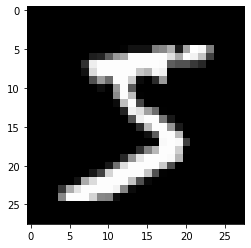

In [5]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In order to take adavntage of PyTorch support for calculating gradients, we need to convert the numpy arrays to PyTorch tensors. See the code example from the last lecture on PyTorch's support for automatic gradient calculation using the back propagation algorithm.

In [6]:
x_train, y_train, x_valid, y_valid, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


For the first part of this self study we will specify a neural network, which will encode a softmax function. For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. 

In [7]:
weights = torch.randn(784, 10) / np.sqrt(784)
print(weights)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

tensor([[ 3.8133e-02, -2.2307e-02,  3.7967e-02,  ..., -2.4189e-04,
         -9.4568e-04, -3.1848e-02],
        [ 3.1047e-02, -1.8964e-02, -5.3290e-04,  ..., -1.3724e-02,
         -4.9714e-02, -1.9803e-02],
        [-1.2769e-01, -1.9871e-02, -2.9242e-03,  ...,  1.3848e-02,
         -9.6237e-02, -3.1801e-02],
        ...,
        [-1.0241e-03, -1.9770e-02, -3.3223e-02,  ...,  5.8534e-02,
          3.5629e-02, -4.8278e-02],
        [ 2.0139e-02,  1.6968e-03, -1.4516e-02,  ..., -2.6358e-02,
         -3.0065e-02,  5.7078e-03],
        [ 2.8457e-02, -6.9453e-02,  1.0701e-05,  ...,  2.1814e-02,
         -5.1264e-02,  2.9715e-02]])


Out model specification

In [8]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

# Below @ refers to matrix multiplication
def model(xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights) using a so-called batch size of 64 (more on this later in the note book); for the prediction we pick out the first element in the batch.

In [9]:
batch_size = 64
xb = x_train[0:batch_size]
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

Batch shape: torch.Size([64, 784])
Prediction on first image tensor([0.0673, 0.1038, 0.0988, 0.0766, 0.1603, 0.0896, 0.1360, 0.0892, 0.0861,
        0.0923], grad_fn=<SelectBackward>)
Corresponding classification: 4


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [10]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean()

loss_func = nll

# Make a test calculation
yb = y_train[0:batch_size]
print(loss_func(preds,yb))


tensor(2.3349, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [11]:
def accuracy(out, yb):
    
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [12]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")
print(preds.shape)

Accuracy of model on batch (with random weights): 0.109375
torch.Size([64, 10])


Now we are ready to combine it all and perform learning

In [16]:
import time

epochs = 4  # how many epochs to train for
lr = 0.05  # learning rate

start = time.time()
train_losses = []
valid_losses = []
momentum = 0.9
v = 0
for epoch in range(epochs):
    for batch_idx in range((n - 1) // batch_size + 1):
        start_i = batch_idx * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        #print(pred)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            #weights -= weights.grad * lr
            v = momentum * v -(weights.grad) ## momentum not sure if well implemented
            weights-=lr*v
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()     
            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = loss_func(model(x_train), y_train)
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)
                       # valid_loss = loss_func(model(x_valid), y_valid)
                        #print(f"Epoch: {epoch}, B-idx: {batch_idx}, valid loss: {valid_loss}")
                        #valid_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: 0.33044344186782837
Epoch: 0, B-idx: 100, Training loss: nan
Epoch: 0, B-idx: 200, Training loss: nan
Epoch: 0, B-idx: 300, Training loss: nan
Epoch: 0, B-idx: 400, Training loss: nan
Epoch: 0, B-idx: 500, Training loss: nan
Epoch: 0, B-idx: 600, Training loss: nan
Epoch: 0, B-idx: 700, Training loss: nan
Epoch: 1, B-idx: 0, Training loss: nan
Epoch: 1, B-idx: 100, Training loss: nan
Epoch: 1, B-idx: 200, Training loss: nan
Epoch: 1, B-idx: 300, Training loss: nan
Epoch: 1, B-idx: 400, Training loss: nan
Epoch: 1, B-idx: 500, Training loss: nan
Epoch: 1, B-idx: 600, Training loss: nan
Epoch: 1, B-idx: 700, Training loss: nan
Epoch: 2, B-idx: 0, Training loss: nan
Epoch: 2, B-idx: 100, Training loss: nan
Epoch: 2, B-idx: 200, Training loss: nan
Epoch: 2, B-idx: 300, Training loss: nan
Epoch: 2, B-idx: 400, Training loss: nan
Epoch: 2, B-idx: 500, Training loss: nan
Epoch: 2, B-idx: 600, Training loss: nan
Epoch: 2, B-idx: 700, Training loss: nan
Epoch:

Plot the evolution of the training loss

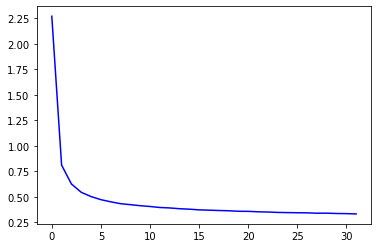

In [14]:
plt.plot(range(len(train_losses)), train_losses,'b')

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results? 
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set (for inspiration, see Line 21 above).

NB: We didn't have time to cover momentum and batch sizes during the last lecture, so please revisit the slides/literature and try to get the gist of this on your own. We will discuss it further at the lecture on Thursday. 

In [15]:



pred_labels=model(x_test)
print(pred_labels)
print(y_valid)

print(f"Accuracy of model on batch (with random weights): {accuracy(pred_labels, y_test)}")


tensor([[1.1843e-04, 1.6155e-07, 1.7715e-04,  ..., 9.9538e-01, 9.2537e-05,
         1.8497e-03],
        [1.0879e-02, 1.2150e-04, 9.0924e-01,  ..., 3.2650e-08, 6.5680e-03,
         1.0433e-06],
        [1.2660e-04, 9.5337e-01, 1.6460e-02,  ..., 5.0805e-03, 9.7125e-03,
         1.5165e-03],
        ...,
        [1.6236e-06, 6.3454e-06, 6.3335e-05,  ..., 4.0679e-03, 1.2782e-02,
         4.4927e-02],
        [1.5373e-03, 3.1172e-03, 6.9479e-04,  ..., 5.2257e-04, 2.5794e-01,
         7.4855e-04],
        [3.4815e-04, 8.5643e-09, 9.4680e-04,  ..., 3.4589e-08, 5.1580e-06,
         9.0236e-07]], grad_fn=<DivBackward0>)
tensor([3, 8, 6,  ..., 5, 6, 8])
Accuracy of model on batch (with random weights): 0.9133999943733215
